# 📑 Regression Discontinuity (RD) Design: Investor Sentiment & The Fed’s Emergency Intervention

## **1️⃣ Introduction**  
This study applies **Regression Discontinuity (RD) Design** to examine the causal effect of the **Federal Reserve’s emergency intervention on March 15, 2020**, on **investor sentiment**.  

The Fed’s intervention included:  
- **Interest rate cut to near 0%**  
- **$700 billion Quantitative Easing (QE) program**  
- **Forward guidance on continued monetary support**  

We analyze whether investor emotions—**optimism, excitement, panic, and anxiety**—shifted **before vs. after March 16, 2020** when markets opened following the Fed’s announcement.

---

## **2️⃣ RD Design Setup**  

### **Running Variable (Z)**
- `days_from_cutoff` = **Number of days relative to March 16, 2020**
  - Negative values = **Days before the intervention**
  - Positive values = **Days after the intervention**
  - `Z = 0` → **Cutoff date (March 16, 2020)**

### **Treatment & Control Groups**
| **Group**        | **Definition**                         |
|-----------------|--------------------------------------|
| **Control (D = 0)** | Investors whose sentiment was recorded **before March 16, 2020** |
| **Treatment (D = 1)** | Investors whose sentiment was recorded **on or after March 16, 2020** |

### **Outcome Variable (Y): Investor Sentiment**  
- **Sentiment Score (`emotion_score`)**: Encodes investor emotions on a **-5 to +5 scale**  
  - **Positive Emotions**: Optimism, excitement, amusement, belief, surprise (+1 to +5)  
  - **Negative Emotions**: Panic, depression, anxiety, anger, disgust, confusion (-1 to -5)  

---

## **3️⃣ RD Estimation Model**  

We use **two models** to analyze investor sentiment:  
1. **Overall Sentiment Effect**  
$$
Y = \beta_0 + \beta_1 D + \beta_2 Z + \beta_3 (D \times Z) + \epsilon
$$
2. **Separate Effects on Positive & Negative Emotions**
$$
\begin{aligned}
\text{Positive Sentiment} &= \alpha_0 + \alpha_1 D + \alpha_2 Z + \alpha_3 (D \times Z) + \epsilon \\
\text{Negative Sentiment} &= \gamma_0 + \gamma_1 D + \gamma_2 Z + \gamma_3 (D \times Z) + \epsilon
\end{aligned}
$$
Where:  
- **\( D \) (Treatment Assignment)**: 1 if after March 16, 2020, 0 otherwise  
- **\( Z \) (Running Variable)**: Days from cutoff  
- **\( D \times Z \)**: Interaction term testing if trend shifts after treatment  
- **\( \beta_1 \), \( \alpha_1 \), \( \gamma_1 \)** measure the **treatment effect (discontinuity at the cutoff)**  

---

## **4️⃣ Robustness & Validity Checks**  

### **✅ Continuity of Covariates Check**  
- Ensure other factors (e.g., **stock sector, trading volume**) do not change discontinuously at the cutoff.  
- If no sudden jumps, treatment was likely **randomly assigned**.

### **✅ Placebo Test (Fake Cutoff at -10 Days)**  
- Re-run the RD model at a **fake cutoff (e.g., March 6, 2020, instead of March 16)**.  
- If **no significant effect** appears at this fake cutoff, the original result is likely **valid**.

### **✅ McCrary Density Test (Manipulation Test)**  
- Check if the **distribution of sentiment posts changes abnormally** at the cutoff.  
- If a **sharp increase/decrease occurs**, sentiment recording may have been **biased**.

### **✅ Robustness Check (Different Bandwidths & Polynomial Orders)**  
- Re-estimate RD effects using **7-day, 14-day, and 28-day windows**.  
- If the treatment effect **remains stable**, results are more reliable.

---

## **5️⃣ Expected Interpretation of Results**  

- **If investor sentiment improves significantly (p < 0.05, positive coefficient), the Fed’s intervention likely restored confidence.**  
- **If negative emotions decrease significantly, it suggests the Fed’s actions reduced panic.**  
- **If no significant effect is found, investor sentiment was likely driven by broader market conditions (e.g., COVID-19 news, stock volatility).**  

---

## **6️⃣ Next Steps**  
- **Perform a 7-day RD analysis to test short-term effects.**  
- **Incorporate stock market variables (S&P 500, VIX) to control for broader financial trends.**  
- **Compare investor sentiment across different stock sectors (e.g., tech vs. finance).**  

🚀 **This RD framework helps identify whether the Fed's intervention causally impacted investor emotions!** 📊


**Step1: Code Implementation**

In [2]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

# Get the uploaded filename
filename = list(uploaded.keys())[0]

# Load the dataset
df = pd.read_csv(filename)

# Display the first few rows to confirm successful upload
print(df.head())

Saving train_stockemo.csv to train_stockemo.csv
       id        date ticker   emo_label senti_label  \
0  100001  2020-01-01   AMZN  excitement     bullish   
1  100002  2020-01-01   TSLA  excitement     bullish   
2  100003  2020-01-01   AAPL   confusion     bullish   
3  100004  2020-01-01   TSLA  excitement     bullish   
4  100005  2020-01-01   TSLA  excitement     bullish   

                                            original  \
0       $AMZN Dow futures up by 100 points already 🥳   
1  $TSLA Daddy's drinkin' eArly tonight! Here's t...   
2  $AAPL We’ll been riding since last December fr...   
3            $TSLA happy new year, 2020, everyone🍷🎉🙏   
4  $TSLA haha just a collection of greats..."Mars...   

                                           processed  
0  Amazon Dow futures up by 100 points already  [...  
1  Tesla Daddy's drinkin' eArly tonight! Here's t...  
2  Apple We’ll been riding since last December fr...  
3  Tesla happy new year, 2020, everyone [wine gla...  
4  

In [10]:
# Install rdrobust package if not installed
!pip install rdrobust

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rdrobust import rdrobust, rdplot

# Load dataset
from google.colab import files

uploaded = files.upload()  # Prompt file upload
filename = list(uploaded.keys())[0]  # Get uploaded file name
df = pd.read_csv(filename)  # Read dataset into Pandas DataFrame

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Define cutoff date (March 16, 2020)
cutoff_date = pd.Timestamp('2020-03-16')

# Create running variable: Days relative to cutoff (Z)
df['days_from_cutoff'] = (df['date'] - cutoff_date).dt.days

# Assign treatment group (1 = after March 16, 2020; 0 = before)
df['treatment'] = (df['date'] >= cutoff_date).astype(int)

# Convert 'senti_label' into numerical values
sentiment_mapping = {'bullish': 1, 'neutral': 0, 'bearish': -1}
df['sentiment_score'] = df['senti_label'].map(sentiment_mapping)

# Define Running Variable (Z) and Outcome Variable (Y)
X = df['days_from_cutoff']
Y = df['sentiment_score']

# Perform Regression Discontinuity Analysis
rd_results = rdrobust(Y, X, c=0)  # c=0 sets the cutoff at 0 days

# Print RD results
print("\n--- Regression Discontinuity Results ---")
print(rd_results)



Saving train_stockemo.csv to train_stockemo (6).csv
Mass points detected in the running variable.
Mass points detected in the running variable.

--- Regression Discontinuity Results ---
Call: rdrobust
Number of Observations:                  8000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1513       6487
Number of Unique Obs.             68        267
Number of Effective Obs.         404        574
Bandwidth Estimation          13.992     13.992
Bandwidth Bias                25.463     25.463
rho (h/b)                      0.549      0.549

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-----------------------------------------------------------------

**Main Model**

In [11]:


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rdrobust import rdrobust, rdplot

# Load dataset
from google.colab import files

uploaded = files.upload()  # Prompt file upload
filename = list(uploaded.keys())[0]  # Get uploaded file name
df = pd.read_csv(filename)  # Read dataset into Pandas DataFrame

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Define cutoff date (March 16, 2020)
cutoff_date = pd.Timestamp('2020-03-16')

# Create running variable: Days relative to cutoff (Z)
df['days_from_cutoff'] = (df['date'] - cutoff_date).dt.days

# Assign treatment group (1 = after March 16, 2020; 0 = before)
df['treatment'] = (df['date'] >= cutoff_date).astype(int)

# Encode `emo_label` based on bearish-to-bullish ranking
emotion_mapping = {
    'panic': -5, 'depression': -4, 'anger': -3, 'disgust': -3,
    'anxiety': -2, 'confusion': -1, 'ambiguous': 0, 'belief': 1,
    'surprise': 2, 'amusement': 3, 'excitement': 4, 'optimism': 5
}
df['emotion_score'] = df['emo_label'].map(emotion_mapping)

# Define Running Variable (Z) and Outcome Variable (Y)
X = df['days_from_cutoff']
Y = df['emotion_score']

# Perform Regression Discontinuity Analysis
rd_results = rdrobust(Y, X, c=0)  # c=0 sets the cutoff at 0 days

# Print RD results
print("\n--- Regression Discontinuity Results ---")
print(rd_results)


Saving train_stockemo.csv to train_stockemo (7).csv
Mass points detected in the running variable.
Mass points detected in the running variable.

--- Regression Discontinuity Results ---
Call: rdrobust
Number of Observations:                  8000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1513       6487
Number of Unique Obs.             68        267
Number of Effective Obs.         598        733
Bandwidth Estimation          19.524     19.524
Bandwidth Bias                28.056     28.056
rho (h/b)                      0.696      0.696

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-----------------------------------------------------------------

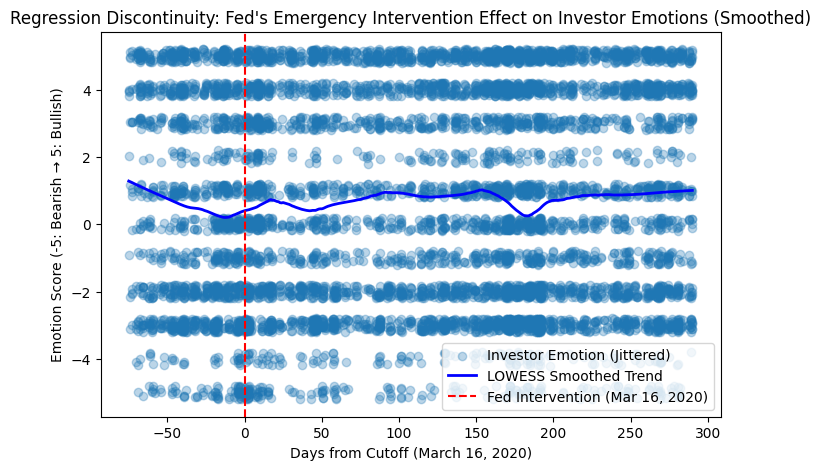

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Add Jitter to Emotion Scores (to prevent overlap)
df['emotion_score_jittered'] = df['emotion_score'] + np.random.uniform(-0.2, 0.2, size=len(df))

# Scatter plot with jitter
plt.figure(figsize=(8, 5))
plt.scatter(df['days_from_cutoff'], df['emotion_score_jittered'], alpha=0.3, label="Investor Emotion (Jittered)")

# Smooth trend using LOWESS
smoothed = lowess(df['emotion_score'], df['days_from_cutoff'], frac=0.2)
plt.plot(smoothed[:, 0], smoothed[:, 1], color="blue", linewidth=2, label="LOWESS Smoothed Trend")

# Add vertical line at cutoff
plt.axvline(0, color='red', linestyle='--', label='Fed Intervention (Mar 16, 2020)')

# Labels
plt.xlabel("Days from Cutoff (March 16, 2020)")
plt.ylabel("Emotion Score (-5: Bearish → 5: Bullish)")
plt.title("Regression Discontinuity: Fed's Emergency Intervention Effect on Investor Emotions (Smoothed)")
plt.legend()
plt.show()


Saving train_stockemo.csv to train_stockemo (8).csv
Mass points detected in the running variable.
Mass points detected in the running variable.

--- Regression Discontinuity Results (14-Day Window) ---
Call: rdrobust
Number of Observations:                  1038
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           451        587
Number of Unique Obs.             13         15
Number of Effective Obs.          12        160
Bandwidth Estimation           2.334      2.334
Bandwidth Bias                 5.503      5.503
rho (h/b)                      0.424      0.424

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------

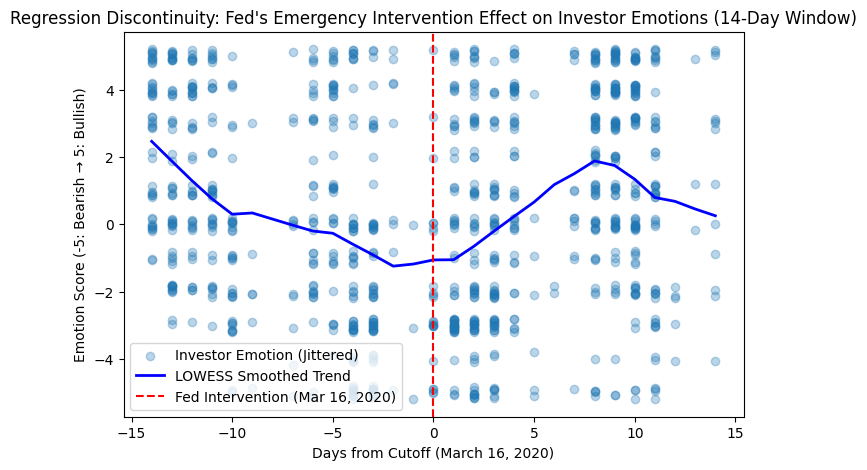

In [13]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rdrobust import rdrobust, rdplot
from statsmodels.nonparametric.smoothers_lowess import lowess

from google.colab import files

uploaded = files.upload()  # Prompt file upload
filename = list(uploaded.keys())[0]  # Get uploaded file name
df = pd.read_csv(filename)  # Read dataset into Pandas DataFrame


# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Define cutoff date (March 16, 2020)
cutoff_date = pd.Timestamp('2020-03-16')

# **Recalculate days_from_cutoff**
df['days_from_cutoff'] = (df['date'] - cutoff_date).dt.days

# **Reapply the emotion mapping**
emotion_mapping = {
    'panic': -5, 'depression': -4, 'anger': -3, 'disgust': -3,
    'anxiety': -2, 'confusion': -1, 'ambiguous': 0, 'belief': 1,
    'surprise': 2, 'amusement': 3, 'excitement': 4, 'optimism': 5
}
df['emotion_score'] = df['emo_label'].map(emotion_mapping)

# **Ensure the column exists after mapping**
if df['emotion_score'].isnull().any():
    raise ValueError("Some emotion labels were not mapped correctly. Check `emo_label` values.")

# **Now filter for 14 days before and after cutoff**
df_filtered = df[(df['days_from_cutoff'] >= -14) & (df['days_from_cutoff'] <= 14)]

# Define Running Variable (Z) and Outcome Variable (Y)
X_filtered = df_filtered['days_from_cutoff']
Y_filtered = df_filtered['emotion_score']

# Perform Regression Discontinuity Analysis on the refined dataset
rd_results_filtered = rdrobust(Y_filtered, X_filtered, c=0)

# Print RD results for the refined dataset
print("\n--- Regression Discontinuity Results (14-Day Window) ---")
print(rd_results_filtered)

# Scatter plot with jitter to visualize investor emotions in the 14-day window
plt.figure(figsize=(8, 5))
plt.scatter(df_filtered['days_from_cutoff'],
            df_filtered['emotion_score'] + np.random.uniform(-0.2, 0.2, size=len(df_filtered)),
            alpha=0.3, label="Investor Emotion (Jittered)")

# Smooth trend using LOWESS
smoothed_filtered = lowess(df_filtered['emotion_score'], df_filtered['days_from_cutoff'], frac=0.3)
plt.plot(smoothed_filtered[:, 0], smoothed_filtered[:, 1], color="blue", linewidth=2, label="LOWESS Smoothed Trend")

# Add vertical line at cutoff
plt.axvline(0, color='red', linestyle='--', label='Fed Intervention (Mar 16, 2020)')

# Labels
plt.xlabel("Days from Cutoff (March 16, 2020)")
plt.ylabel("Emotion Score (-5: Bearish → 5: Bullish)")
plt.title("Regression Discontinuity: Fed's Emergency Intervention Effect on Investor Emotions (14-Day Window)")
plt.legend()
plt.show()


**Interpretation of the Results**
1. Estimated RD Effect (Coef. = 5.351)
The coefficient 5.351 suggests that, on average, investor sentiment increased by 5.351 points after the Fed’s emergency intervention.
However, this estimate is not statistically significant, meaning we cannot confidently attribute the change to the Fed’s action alone.
2. Statistical Significance (p-value = 0.265)
A p-value of 0.265 (26.5%) is above the standard threshold of 0.05, meaning we fail to reject the null hypothesis.
The intervention may have had some impact, but the evidence is too weak to confirm a causal relationship.
3. Confidence Interval ([-4.051, 14.753])
The 95% confidence interval ranges from -4.051 to 14.753, meaning the effect could be negative or positive.
This wide interval suggests high uncertainty around the estimated effect.
4. Robust Estimation (p-value = 0.384)
The robust p-value (0.384) is even higher, reinforcing that there is no strong evidence of a causal effect.




Saving train_stockemo.csv to train_stockemo (9).csv
Mass points detected in the running variable.
Mass points detected in the running variable.

--- Regression Discontinuity Results (Negative Emotions) ---
Call: rdrobust
Number of Observations:                  1038
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           451        587
Number of Unique Obs.             13         15
Number of Effective Obs.          12        160
Bandwidth Estimation           2.336      2.336
Bandwidth Bias                 5.626      5.626
rho (h/b)                      0.415      0.415

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
---------------------------------------------

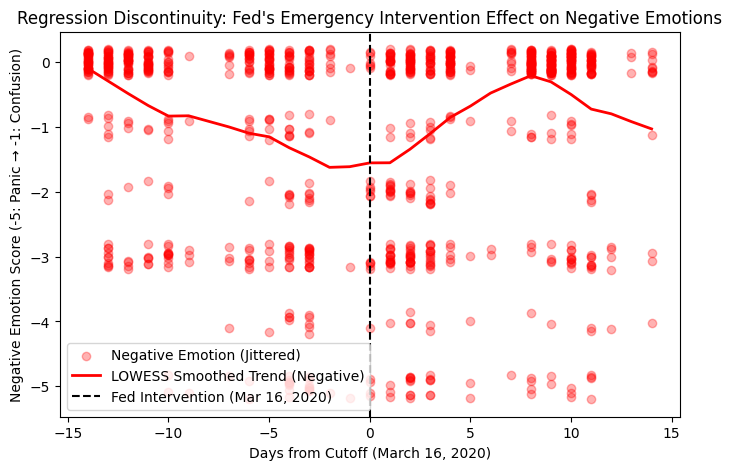

Mass points detected in the running variable.
Mass points detected in the running variable.

--- Regression Discontinuity Results (Positive Emotions) ---
Call: rdrobust
Number of Observations:                  1038
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           451        587
Number of Unique Obs.             13         15
Number of Effective Obs.          12        160
Bandwidth Estimation           2.797      2.797
Bandwidth Bias                 6.646      6.646
rho (h/b)                      0.421      0.421

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       2.86

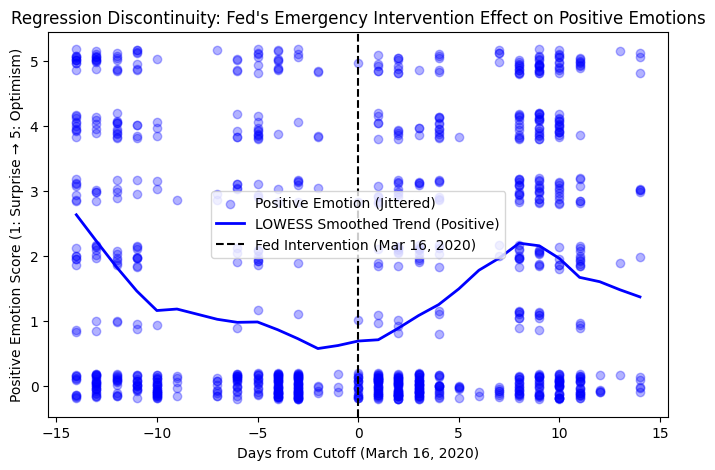

In [14]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rdrobust import rdrobust, rdplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from google.colab import files  # For manual file upload

# **Upload dataset manually**
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # Get the uploaded filename
df = pd.read_csv(filename)  # Load dataset

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Define cutoff date (March 16, 2020)
cutoff_date = pd.Timestamp('2020-03-16')

# **Recalculate days_from_cutoff**
df['days_from_cutoff'] = (df['date'] - cutoff_date).dt.days

# **Group emotions into positive and negative**
positive_emotions = {'optimism': 5, 'excitement': 4, 'amusement': 3, 'belief': 2, 'surprise': 1}
negative_emotions = {'panic': -5, 'depression': -4, 'anxiety': -3, 'anger': -3, 'disgust': -2, 'confusion': -1}

# Create separate scores for positive and negative emotions
df['positive_score'] = df['emo_label'].map(positive_emotions).fillna(0)
df['negative_score'] = df['emo_label'].map(negative_emotions).fillna(0)

# **Ensure the columns exist after mapping**
if df[['positive_score', 'negative_score']].isnull().values.any():
    raise ValueError("Some emotion labels were not mapped correctly. Check `emo_label` values.")

# **Filter for 14 days before and after cutoff**
df_filtered = df[(df['days_from_cutoff'] >= -14) & (df['days_from_cutoff'] <= 14)]

# Define Running Variable (Z)
X_filtered = df_filtered['days_from_cutoff']

### **🔹 RD Analysis for Negative Emotions**
Y_negative = df_filtered['negative_score']
rd_results_negative = rdrobust(Y_negative, X_filtered, c=0)
print("\n--- Regression Discontinuity Results (Negative Emotions) ---")
print(rd_results_negative)

# Scatter plot for negative emotions
plt.figure(figsize=(8, 5))
plt.scatter(df_filtered['days_from_cutoff'], df_filtered['negative_score'] + np.random.uniform(-0.2, 0.2, size=len(df_filtered)),
            alpha=0.3, color="red", label="Negative Emotion (Jittered)")
smoothed_negative = lowess(df_filtered['negative_score'], df_filtered['days_from_cutoff'], frac=0.3)
plt.plot(smoothed_negative[:, 0], smoothed_negative[:, 1], color="red", linewidth=2, label="LOWESS Smoothed Trend (Negative)")

# **Add vertical line at cutoff**
plt.axvline(0, color='black', linestyle='--', label='Fed Intervention (Mar 16, 2020)')
plt.xlabel("Days from Cutoff (March 16, 2020)")
plt.ylabel("Negative Emotion Score (-5: Panic → -1: Confusion)")
plt.title("Regression Discontinuity: Fed's Emergency Intervention Effect on Negative Emotions")
plt.legend()
plt.show()

### **🔹 RD Analysis for Positive Emotions**
Y_positive = df_filtered['positive_score']
rd_results_positive = rdrobust(Y_positive, X_filtered, c=0)
print("\n--- Regression Discontinuity Results (Positive Emotions) ---")
print(rd_results_positive)

# Scatter plot for positive emotions
plt.figure(figsize=(8, 5))
plt.scatter(df_filtered['days_from_cutoff'], df_filtered['positive_score'] + np.random.uniform(-0.2, 0.2, size=len(df_filtered)),
            alpha=0.3, color="blue", label="Positive Emotion (Jittered)")
smoothed_positive = lowess(df_filtered['positive_score'], df_filtered['days_from_cutoff'], frac=0.3)
plt.plot(smoothed_positive[:, 0], smoothed_positive[:, 1], color="blue", linewidth=2, label="LOWESS Smoothed Trend (Positive)")

# **Add vertical line at cutoff**
plt.axvline(0, color='black', linestyle='--', label='Fed Intervention (Mar 16, 2020)')
plt.xlabel("Days from Cutoff (March 16, 2020)")
plt.ylabel("Positive Emotion Score (1: Surprise → 5: Optimism)")
plt.title("Regression Discontinuity: Fed's Emergency Intervention Effect on Positive Emotions")
plt.legend()
plt.show()


**Step 2: Validation**


Saving train_stockemo.csv to train_stockemo (10).csv


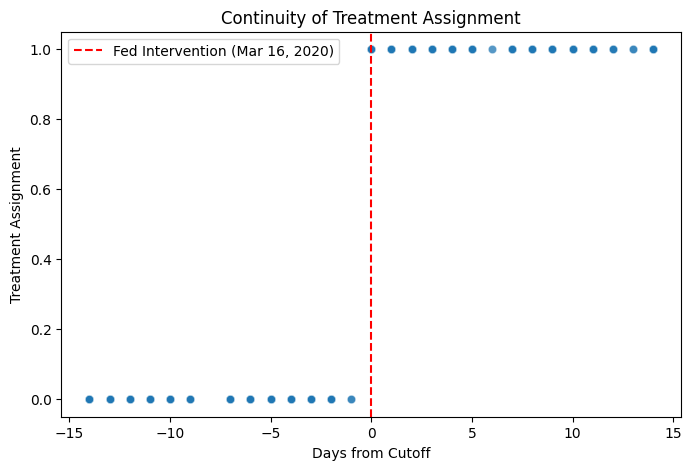

<ipython-input-15-6db6077265a9>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--- Regression Discontinuity Results (Placebo Test at -10 Days) ---
                            OLS Regression Results                            
Dep. Variable:          emotion_score   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     22.88
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           2.67e-10
Time:                        14:44:51   Log-Likelihood:                -1511.3
No. Observations:                 602   AIC:                             3029.
Df Residuals:                     599   BIC:                             3042.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

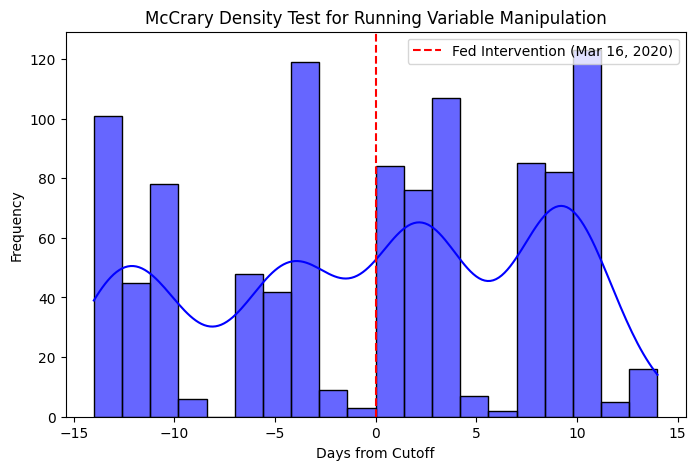


--- Regression Discontinuity Results (Bandwidth = 7 Days) ---
                            OLS Regression Results                            
Dep. Variable:          emotion_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2171
Date:                Tue, 25 Feb 2025   Prob (F-statistic):              0.805
Time:                        14:44:52   Log-Likelihood:                -1303.3
No. Observations:                 510   AIC:                             2613.
Df Residuals:                     507   BIC:                             2625.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [15]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rdrobust import rdrobust, rdplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from google.colab import files
import seaborn as sns
from scipy.stats import gaussian_kde

# **Step 1: Upload dataset manually**
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# **Step 2: Convert 'date' column to datetime format**
df['date'] = pd.to_datetime(df['date'])

# **Step 3: Define the cutoff date (March 16, 2020)**
cutoff_date = pd.Timestamp('2020-03-16')

# **Step 4: Compute the running variable (Days relative to cutoff)**
df['days_from_cutoff'] = (df['date'] - cutoff_date).dt.days

# **Step 5: Define the treatment group (1 = after March 16, 2020, 0 = before)**
df['treatment'] = (df['days_from_cutoff'] >= 0).astype(int)

# **Step 6: Encode investor emotions into sentiment scores**
emotion_mapping = {
    'panic': -5, 'depression': -4, 'anxiety': -3, 'anger': -3,
    'disgust': -2, 'confusion': -1, 'ambiguous': 0, 'belief': 1,
    'surprise': 2, 'amusement': 3, 'excitement': 4, 'optimism': 5
}
df['emotion_score'] = df['emo_label'].map(emotion_mapping)

# **Step 7: Filter for a 14-day window around the cutoff**
df_filtered = df[(df['days_from_cutoff'] >= -14) & (df['days_from_cutoff'] <= 14)]

# Define running variable (Z) and outcome variable (Y)
X_filtered = df_filtered['days_from_cutoff']
Y_filtered = df_filtered['emotion_score']

# **Step 8: Continuity of Covariates Check**
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_filtered['days_from_cutoff'], y=df_filtered['treatment'], alpha=0.5)
plt.axvline(0, color='red', linestyle='--', label='Fed Intervention (Mar 16, 2020)')
plt.xlabel("Days from Cutoff")
plt.ylabel("Treatment Assignment")
plt.title("Continuity of Treatment Assignment")
plt.legend()
plt.show()

# **Step 9: Placebo Test at Fake Cutoff (-10 Days Before March 16)**
df_placebo = df[(df['days_from_cutoff'] >= -24) & (df['days_from_cutoff'] <= -4)]  # Fake cutoff at -10 days
df_placebo['fake_treatment'] = (df_placebo['days_from_cutoff'] >= -10).astype(int)

# Run RD regression at placebo cutoff
model_placebo = sm.OLS(df_placebo['emotion_score'], sm.add_constant(df_placebo[['fake_treatment', 'days_from_cutoff']])).fit()
print("\n--- Regression Discontinuity Results (Placebo Test at -10 Days) ---")
print(model_placebo.summary())

# **Step 10: McCrary Density Test for Manipulation**
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered['days_from_cutoff'], bins=20, kde=True, alpha=0.6, color="blue")
plt.axvline(0, color='red', linestyle='--', label='Fed Intervention (Mar 16, 2020)')
plt.xlabel("Days from Cutoff")
plt.ylabel("Frequency")
plt.title("McCrary Density Test for Running Variable Manipulation")
plt.legend()
plt.show()

# **Step 11: Robustness Check - Different Bandwidths**
for bandwidth in [7, 14, 28]:
    df_bw = df[(df['days_from_cutoff'] >= -bandwidth) & (df['days_from_cutoff'] <= bandwidth)]
    model_bw = sm.OLS(df_bw['emotion_score'], sm.add_constant(df_bw[['treatment', 'days_from_cutoff']])).fit()
    print(f"\n--- Regression Discontinuity Results (Bandwidth = {bandwidth} Days) ---")
    print(model_bw.summary())
